In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import glob, pdb, os, sys, cv2
from ripser import ripser
from persim import plot_diagrams
#import gudhi as gd
#from angio import angio_abm, radial_persistence, level_set_flooding, Persist_im
import matplotlib as mpl
from sklearn import svm
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf') 

from custom_function import *

In [2]:
chi_vec = np.round(np.linspace(.3,.1,5),2)
hapt_vec = np.round(np.linspace(.25,.45,5),2)

psi_vec = np.round(np.linspace(0.1,1,10),2)

topo = 'plane' #plane , flood
#summary = Betti #Betti, persim

num_data_sets = 10*len(chi_vec)*len(psi_vec)

feature_len_persim = 2500

b0_persim_ones = []
b1_persim_ones = []
b0_persim_ramp = []
b1_persim_ramp = []

for i in np.arange(4):
    b0_persim_ones.append(np.zeros((num_data_sets,feature_len_persim)))
    b1_persim_ones.append(np.zeros((num_data_sets,feature_len_persim)))
    b0_persim_ramp.append(np.zeros((num_data_sets,feature_len_persim)))
    b1_persim_ramp.append(np.zeros((num_data_sets,feature_len_persim)))


feature_len_Betti = 25

b0_betti = []
b1_betti = []

for i in np.arange(4):
    b0_betti.append(np.zeros((num_data_sets,feature_len_Betti)))
    b1_betti.append(np.zeros((num_data_sets,feature_len_Betti)))

labels = np.zeros((num_data_sets,))
chi_rho_real_vec = np.zeros((num_data_sets,))
psi_real_vec = np.zeros((num_data_sets,))
real_vec = np.zeros((num_data_sets,))
    
count = 0
for i,(chi,hapt) in enumerate(zip(chi_vec,hapt_vec)):
    for j,psi in enumerate(psi_vec):
        for real in np.arange(10):
            for k,orient in enumerate(['left','right','top','bottom']):
            
                #load in persistence images
                mat = np.load("results/angio_"+topo+"_"+orient+"_persim_ramp_IC_linear_rho_"+str(hapt)+"_chi_"+str(chi)+"_psi_"+str(psi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
                b0_persim_ramp[k][count,:] = mat['Ip'][0].reshape(-1)
                b1_persim_ramp[k][count,:] = mat['Ip'][1].reshape(-1)

                mat = np.load("results/angio_"+topo+"_"+orient+"_persim_ones_IC_linear_rho_"+str(hapt)+"_chi_"+str(chi)+"_psi_"+str(psi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()
                b0_persim_ones[k][count,:] = mat['Ip'][0].reshape(-1)
                b1_persim_ones[k][count,:] = mat['Ip'][1].reshape(-1)


                mat = np.load("results/angio_"+topo+"_"+orient+"_Betti_IC_linear_rho_"+str(hapt)+"_chi_"+str(chi)+"_psi_"+str(psi)+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()

                b0_betti[k][count,:] = mat['b0']
                b1_betti[k][count,:] = mat['b1']

            
            chi_rho_real_vec[count] = i
            psi_real_vec[count] = psi
            labels[count] = len(hapt_vec)*i + j
            
            real_vec[count] = real

                
            count+=1

## ELbow curve for number of clusters

In [ ]:
X_vec = [b0_persim_ones]#[b0_persim_ones,b1_persim_ones,b0_persim_ramp,b1_persim_ramp,b0_betti,b1_betti]
title_vec = ["b0_left_persim_ones"]#,"b1_persim_ones","b0_persim_ramp","b1_persim_ramp","b0_betti","b1_betti"]
y = labels

title_vec_print = []
print_scores = []

score_vec = np.zeros((9,))
plt.figure()        
for i,X in enumerate(X_vec):


    for num_clusters in np.arange(1,10):
        #### perform clustering
        filename = "Classes_"+title_vec[i]
        #kmeans_classes,acc = clustering_fine_train_test(X,chi_real_vec,rho_real_vec,real_vec,num_clusters=5,filename = "param_clustering_"+title_vec[0]+"_"+topo)
        kmeans_classes,acc = clustering_fine_train_test(X,chi_real_vec,rho_real_vec,real_vec,num_clusters=num_clusters)#,filename = "param_clustering_"+title_vec[0]+"_"+topo)
        score_vec[num_clusters-1] = acc


    plt.plot(score_vec,label = title_vec[i])
    
plt.legend()


## Running classification scheme

<IPython.core.display.Javascript object>


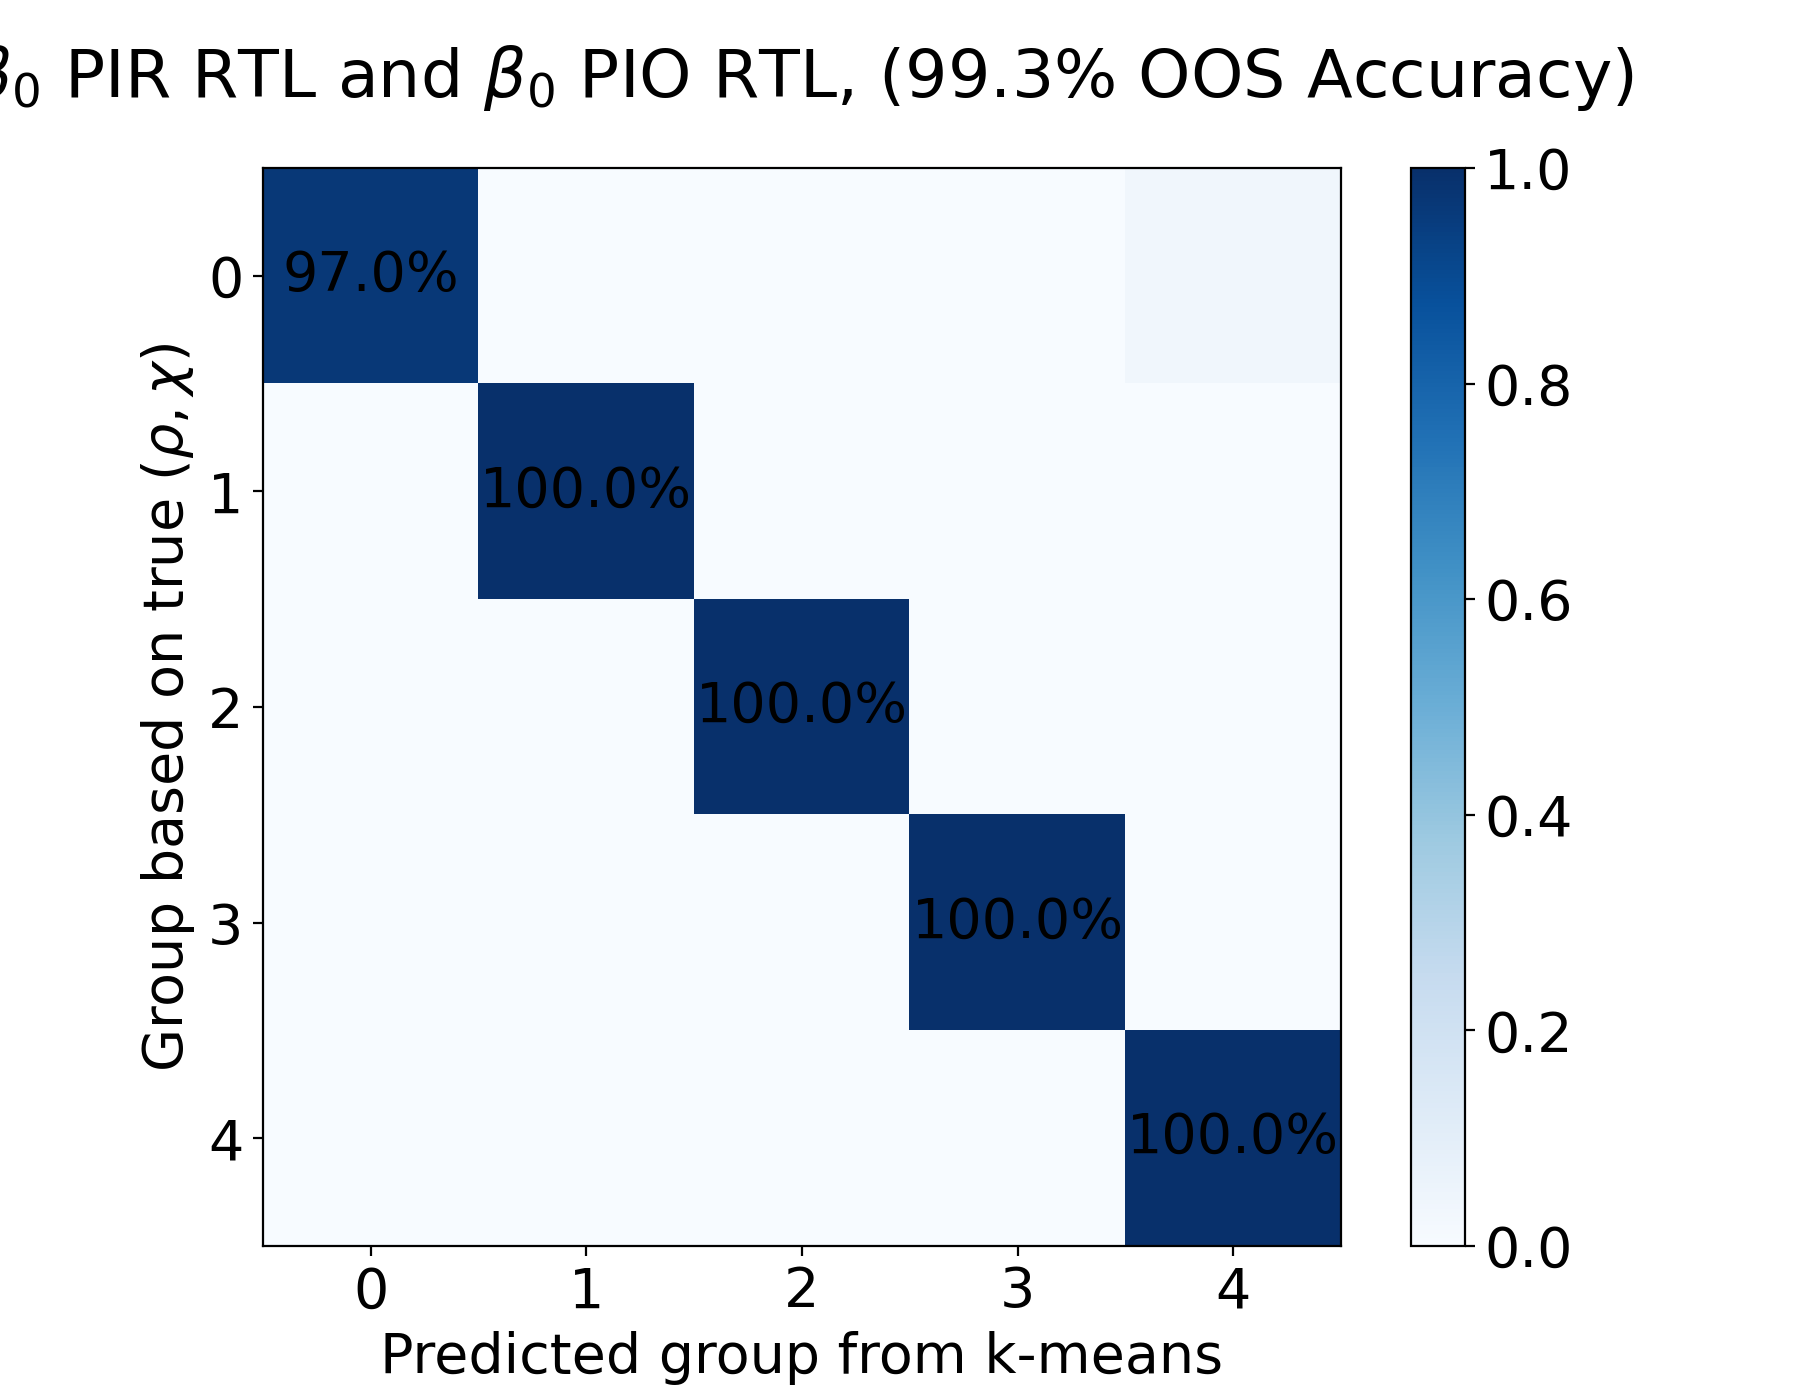

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>


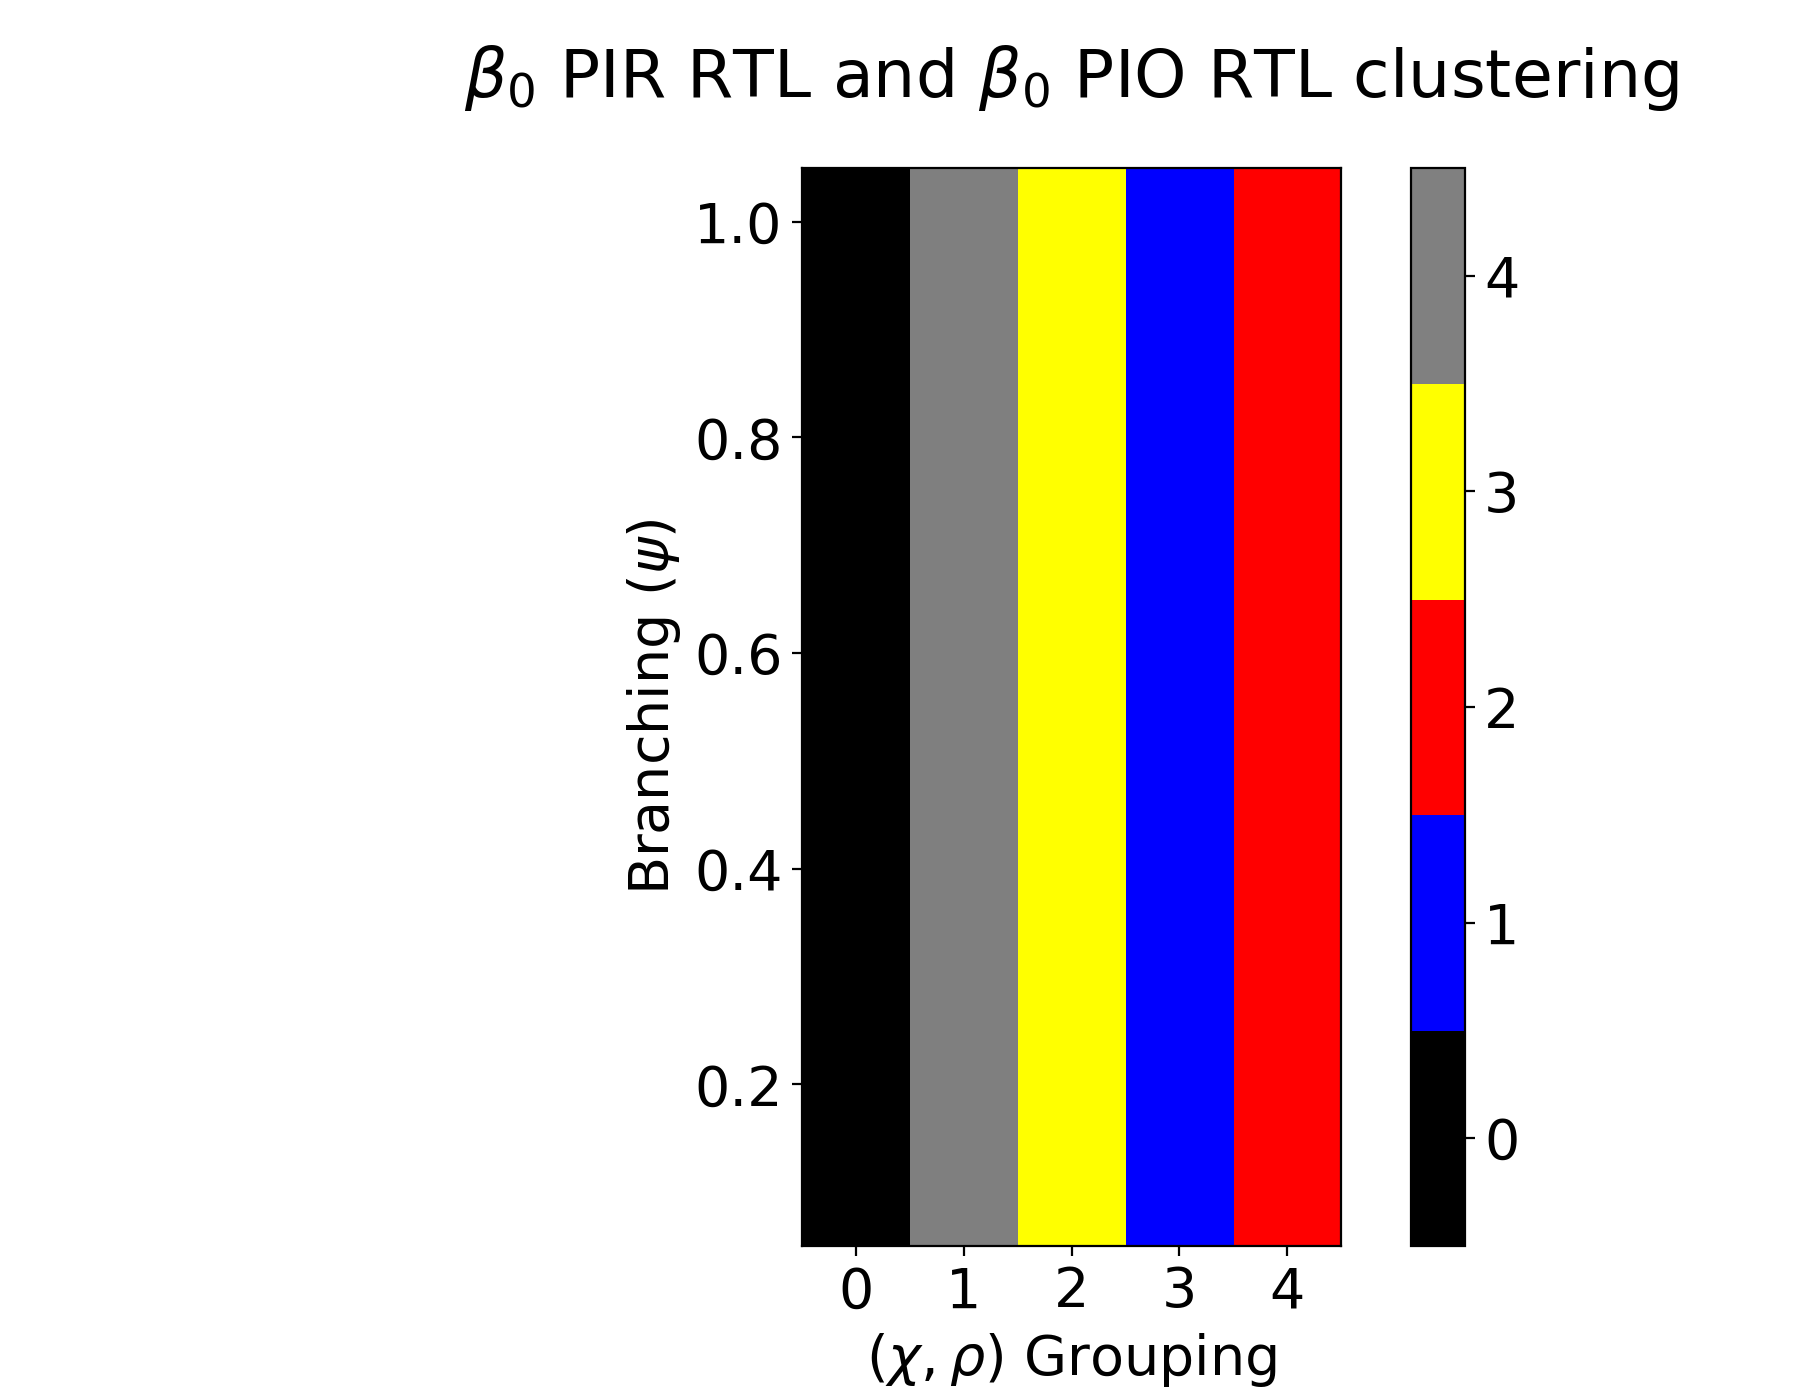

b0_PIR_RTL_and_b0_PIO_RTL, acc = 0.9933333333333333


In [3]:
'''X_vec = [b0_persim_ramp,b1_persim_ramp,b0_persim_ones,b1_persim_ones,b0_betti,b1_betti]
title_vec = ["b0_persim_ramp","b1_persim_ramp","b0_persim_ones","b1_persim_ones","b0_betti","b1_betti"]

X_vec = b0_persim_ones + b1_persim_ones  + b0_persim_ramp + b1_persim_ramp + b0_betti + b1_betti
feats = ['persim_ones','persim_ramp','betti']
orients = ['left','right','top','bottom']
title_vec = []
for feat in feats:
    for i in np.arange(2):
        for orient in orients:
            title_vec.append("b"+str(i)+"_"+orient+"_"+feat)
'''

X_vec = [np.hstack((b0_persim_ramp[1],b0_persim_ones[1]))]
title_vec = ["b0_PIR_RTL_and_b0_PIO_RTL"]#,"b1_persim_ramp","b0_persim_ones","b1_persim_ones","b0_betti","b1_betti"]
title_vec_fig = [r"$\beta_0$ PIR RTL and $\beta_0$ PIO RTL"]
y = labels


#### perform clustering
#filename = "Classes_"+title_vec[i]
for i,X in enumerate(X_vec):
    kmeans_classes,acc,acc_in_sample = clustering_fine_train_test(X,psi_real_vec,chi_rho_real_vec,
                                                real_vec,num_clusters=5,
                                                filename = "param_clustering_"+title_vec[i]+"_"+topo,title=title_vec_fig[i])

    print(title_vec[i] + ", acc = " + str(acc))



## Run Classification for B0 and B1

In [ ]:
X_vec = []
for i in np.arange(4):
    X_vec.append(np.hstack((b0_persim_ramp[i],b1_persim_ramp[i])))
for i in np.arange(4):
    X_vec.append(np.hstack((b0_persim_ones[i],b1_persim_ones[i])))
for i in np.arange(4):
    X_vec.append(np.hstack((b0_betti[i],b1_betti[i])))
    
feats = ['persim_ramp','persim_ones','betti']
orients = ['left','right','top','bottom']
title_vec = []
for feat in feats:
    for orient in orients:
            title_vec.append("b0_and_b1_"+orient+"_"+feat)
            
y = labels


#### perform clustering
#filename = "Classes_"+title_vec[i]
for i,X in enumerate(X_vec):
    kmeans_classes,acc,cm = clustering_fine_train_test(X,chi_real_vec,rho_real_vec,
                                                real_vec,num_clusters=5)#,
                                                #filename = "param_clustering_"+title_vec[0]+"_"+topo)

    print(title_vec[i] + ", acc = " + str(acc))




## Add left,right and top,bottom

In [ ]:
X_vec = []
for i in np.arange(2):
    X_vec.append(np.hstack((b0_persim_ramp[i],b0_persim_ramp[i+1])))
for i in np.arange(2):
    X_vec.append(np.hstack((b1_persim_ramp[i],b1_persim_ramp[i+1])))
for i in np.arange(2):
    X_vec.append(np.hstack((b0_persim_ones[i],b0_persim_ones[i+1])))
for i in np.arange(2):
    X_vec.append(np.hstack((b1_persim_ones[i],b1_persim_ones[i+1])))
for i in np.arange(2):
    X_vec.append(np.hstack((b0_betti[i],b0_betti[i+1])))
for i in np.arange(2):
    X_vec.append(np.hstack((b1_betti[i],b1_betti[i+1])))

    
feats = ['persim_ramp','persim_ones','betti']
orients = ['left_and_right','top_and_bottom']
title_vec = []
for feat in feats:
    for i in np.arange(2):
        for orient in orients:
            title_vec.append("b"+str(i)+"_"+orient+"_"+feat)            
            
            
y = labels


#### perform clustering
#filename = "Classes_"+title_vec[i]
for i,X in enumerate(X_vec):
    kmeans_classes,acc,cm = clustering_fine_train_test(X,chi_rho_real_vec,psi_real_vec,
                                                real_vec,num_clusters=2,
                                                filename = "param_clustering_"+title_vec[i]+"_"+topo+"_psi")

    #print(title_vec[i] + ", acc = " + str(acc))





## Creating Accuracy Table

In [ ]:
###
### All doubles of feature vectors
###
X_vec_ind = b0_persim_ones + b1_persim_ones  + b0_persim_ramp + b1_persim_ramp + b0_betti + b1_betti
feats = ['PIO','PIR','BC']
orients = ['LTR','RTL','TTB','BTT']
title_vec_ind = []
for feat in feats:
    for i in np.arange(2):
        for orient in orients:
            title_vec_ind.append(r"$\beta_"+str(i)+"$ "+orient+" "+feat)#title_vec_ind.append("b"+str(i)+"\_"+orient+"\_"+feat)#title_vec.append(r"$\beta_"+str(i)+"$ "+orient+" "+feat)          
X_vec = []
title_vec = []
for i in np.arange(len(X_vec_ind)):
    for j in np.arange(i+1,len(X_vec_ind)):
        X_vec.append(np.hstack((X_vec_ind[i],X_vec_ind[j])))
        title_vec.append(title_vec_ind[i] + " and " + title_vec_ind[j])

create_latex_table_classification_sort(X_vec,title_vec,psi_real_vec,
                                  chi_rho_real_vec,real_vec,num_clusters=5)



In [ ]:
class_num = np.max(kmeans_classes) + 1

#
#for kclass in np.arange(class_num):
fig = plt.figure()
count = 1

for i in np.arange(3):
    for kclass in np.arange(class_num):
#    for i in np.arange(6):
    
        #find all realizations of this class
        class_reals = np.where(kmeans_classes==kclass)[0]
        #randomly pick one
        random_sample = np.random.permutation(class_reals)[0]

        #find real, hapt, chi
        real = random_sample%10
        hapt = (random_sample%(len(hapt_vec)*10))//10
        chi = random_sample//(len(hapt_vec)*10)

        #load in bio data
        mat = np.load("results/angio_bio_data_IC_linear_rho_"+str(hapt_vec[hapt])+"_chi_"+str(chi_vec[chi])+"_real_"+str(real)+".npy",allow_pickle=True,encoding="latin1").item()

        #plot network
        ax = fig.add_subplot(3,class_num,count)
        ax.matshow(mat['N'].T)
        ax.set_xticks([])
        ax.set_yticks([])
        if i ==0:
            ax.set_title("Class " + str(kclass))
        count += 1
plt.savefig("figures/cluster_examples_"+title_vec[0]+"_"+topo+".pdf",format="pdf")

In [ ]:
class_reals = np.where(kmeans_classes==1)[0]
#randomly pick one
random_sample = np.random.permutation(class_reals)[0]

#find real, hapt, chi
real = random_sample%10
hapt = (random_sample%(len(hapt_vec)*10))//10
chi = random_sample//(len(hapt_vec)*10)

"results/angio_bio_data_IC_linear_rho_"+str(hapt_vec[hapt])+"_chi_"+str(chi_vec[chi])+"_real_"+str(real)+".npy"